In [ ]:
!pip install kaggle


In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download -d prasunroy/natural-images


Dataset URL: https://www.kaggle.com/datasets/prasunroy/natural-images
License(s): CC-BY-NC-SA-4.0
 96% 329M/342M [00:02<00:00, 137MB/s]
100% 342M/342M [00:02<00:00, 146MB/s]


In [ ]:
!unzip natural-images.zip


unzip:  cannot find or open natural-images.zip, natural-images.zip.zip or natural-images.zip.ZIP.


In [ ]:
import os
from PIL import Image
import pandas as pd

from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, sampler, random_split
import torch.nn as nn
from torch import optim, cuda
import torch

In [ ]:
tag_classes = os.listdir('./natural_images')
tag_classes

FileNotFoundError: ignored

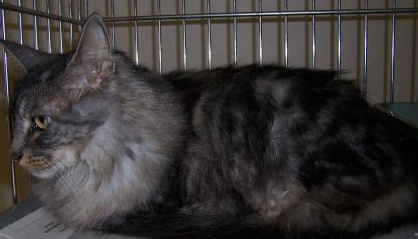

In [ ]:
#Display random image
Image.open('./natural_images/cat/cat_0009.jpg')

In [ ]:
n_image = []

In [ ]:
for folder in os.listdir('./natural_images'):
    # classes.append(folder)

    # Number of each image
    images = os.listdir('./natural_images/'+folder)
    n_image.append(len(images))

NameError: ignored

In [ ]:
df = pd.DataFrame({
    'classes': tag_classes,
    'number': n_image
})

df

,classes,number
0,airplane,727
1,car,968
2,fruit,1000
3,cat,885
4,motorbike,788
5,flower,843
6,dog,702
7,person,986


In [ ]:
image_transform = transforms.Compose([

    # Resize all IMGs
    transforms.Resize(size=(256,256)),
    # Random vertical flip
    transforms.RandomVerticalFlip(),
    # Random horizental flip
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # Commonly used std and mean for pre-trained models on natural image datasets
    transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [ ]:
batch_size = 64


# Load a dataset where each class of images is stored in a separate directory.
data_set = datasets.ImageFolder(root= "./natural_images")


# Split dataset to train and test
train_data, test_data = random_split(data_set, [0.8, 0.2])

# Transform data
train_data.dataset.transform = image_transform
test_data.dataset.transform = image_transform

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


print("Length of train dataset: ", len(train_data))
print("Length of test dataset: ", len(test_data))



Length of train dataset:  5520
Length of test dataset:  1379


In [ ]:
# Get a sample

sample_image, _ = train_data[0]  # Retrieve the first image sample
print(" Sample's shape: ", sample_image.shape)


 Sample's shape:  torch.Size([3, 256, 256])


# VGG
VGG is a classical convolutional neural network architecture. It was based on an analysis of how to increase the depth of such networks. The network utilises small 3 x 3 filters. Otherwise the network is characterized by its simplicity: the only other components being pooling layers and a fully connected layer.

In [ ]:
model = models.vgg16(pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 176MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Required_grad
This is an attribute of a tensor in PyTorch that specifies whether gradients should be computed with respect to this tensor during backpropagation.

Here we set it false, because we want to use pretrained model and it take extremely long if we were to retrain it due to the sheer amount of layers

In [ ]:
# Freeze early layers
for param in model.parameters():
    param.requires_grad = False

In [ ]:
n_classes = 8
n_inputs = model.classifier[6].in_features
print("Number of features",n_inputs)


# Add on classifier
model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, n_classes),
    nn.LogSoftmax(dim=1))

model.classifier


Number of features 4096


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=8, bias=True)
    (4): LogSoftmax(dim=1)
  )
)

# Negative Log Likelihood Loss

Negative log-likelihood is a loss function used in multi-class classification.

Calculated as −log(y)
−log(y), where y
y is a prediction corresponding to the true label, after the Softmax Activation Functionon.md) was applied. The loss for a mini-batch is computed by taking the mean or sum of all items in the batch.



In [ ]:
# Negative Log Likelihood Loss
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.cuda()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
def train(model,
         criterion,
         optimizer,
         train_loader,
         n_epochs=10):
  total_step = len(train_loader)
  # Training loop
  for epoch in range(n_epochs):
    model.train()

    step = 1
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    for inputs, targets in train_loader:

        inputs = inputs.cuda()
        targets = targets.cuda()
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()


        total_loss += loss.item() * inputs.size(0)

        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        total_predictions += targets.size(0)
        correct_predictions += (predicted == targets).sum().item()

        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, n_epochs, step, total_step, loss.item()))
        step += 1

    print('Epoch finished')
    average_loss = total_loss / len(train_loader.dataset)
    accuracy = correct_predictions / total_predictions

    print(f"Epoch [{epoch + 1}/{n_epochs}] - Average Loss: {average_loss}, Accuracy: {accuracy}")




  print('Training finished!')
  return model, average_loss, accuracy


In [ ]:
model, average_loss, accuracy = train(model,
    criterion,
    optimizer,
    train_loader,n_epochs=10)

In [ ]:
def test(model, test_loader, criterion):
  model.eval()  # Set the model to evaluation mode

  total_loss = 0.0
  correct_predictions = 0
  total_predictions = 0

  with torch.no_grad():  # Disable gradient calculation
      for inputs, targets in test_loader:
          # Move inputs and targets to the specified device
          inputs, targets = inputs.cuda(), targets.cuda()

          # Forward pass
          outputs = model(inputs)

          # Compute loss
          loss = criterion(outputs, targets)

          total_loss += loss.item() * inputs.size(0)

          # Compute accuracy
          _, predicted = torch.max(outputs, 1)
          total_predictions += targets.size(0)
          correct_predictions += (predicted == targets).sum().item()

  # Calculate average loss and accuracy for the test set
  average_loss = total_loss / len(test_loader.dataset)
  accuracy = correct_predictions / total_predictions

  return average_loss, accuracy


In [ ]:
avg_loss, test_acc = test(model.cuda(), test_loader, criterion)

In [ ]:
print(f'accuracy of model: {100 * test_acc:.2f}% on the test dataset')


accuracy of model: 99.20% on the test dataset


#Alexnet

AlexNet is a convolutional neural network that is 8 layers deep. pretrained version of the network trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals.

In [ ]:
alex_net= models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:00<00:00, 297MB/s]


In [ ]:
# freez the model
for param in alex_net.parameters():
    param.requires_grad=False

In [ ]:
n_inputs = alex_net.classifier
print(n_inputs)
# alex_net.classifier = nn.sequential()

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [ ]:
n_inputs = alex_net.classifier[1].in_features

In [ ]:
alex_net.classifier = nn.Sequential(nn.Dropout(p=0.5),
                                    nn.Linear(n_inputs,4096, bias=True),
                                    nn.ReLU(),
                                    nn.Dropout(p=0.5),
                                    nn.Linear(4096,4096),
                                    nn.ReLU(),
                                    nn.Linear(4096,n_classes),
                                    nn.LogSoftmax(dim=1))

alex_net.cuda()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# Cross Entropy Loss
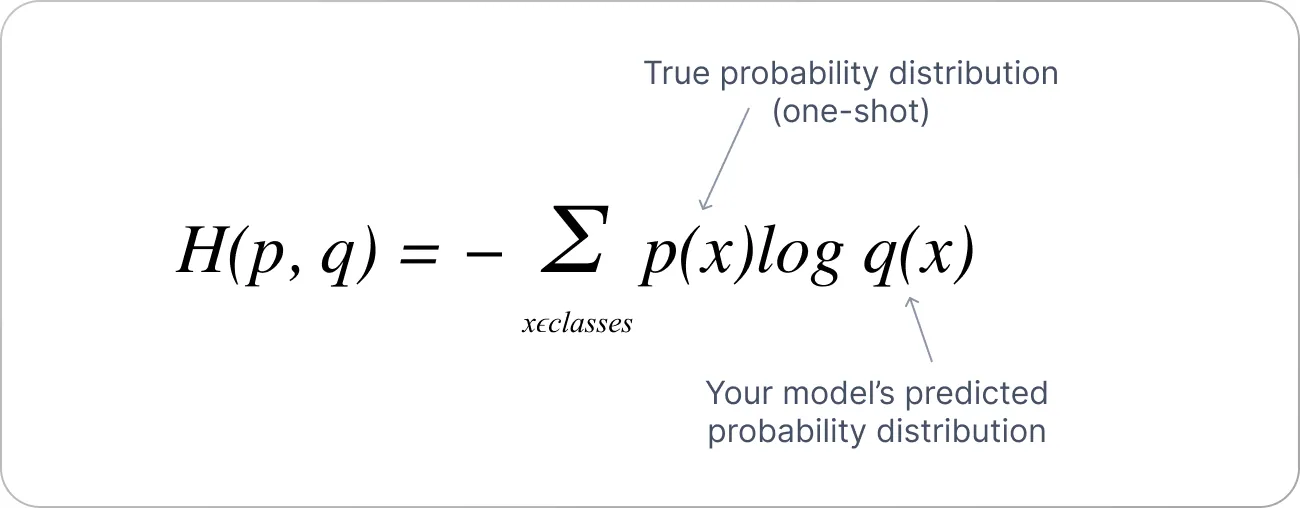

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alex_net.classifier.parameters(),lr=0.001)
alex_net.cuda()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
alex_net, average_loss, accuracy = train(alex_net,
    criterion,
    optimizer,
    train_loader,n_epochs=10)

Epoch [1/10], Step [1/87], Loss: 2.1076
Epoch [1/10], Step [2/87], Loss: 10.9388
Epoch [1/10], Step [3/87], Loss: 9.2290
Epoch [1/10], Step [4/87], Loss: 5.5823
Epoch [1/10], Step [5/87], Loss: 3.7171
Epoch [1/10], Step [6/87], Loss: 1.5096
Epoch [1/10], Step [7/87], Loss: 0.7597
Epoch [1/10], Step [8/87], Loss: 0.5532
Epoch [1/10], Step [9/87], Loss: 0.5431
Epoch [1/10], Step [10/87], Loss: 0.2265
Epoch [1/10], Step [11/87], Loss: 0.2490
Epoch [1/10], Step [12/87], Loss: 0.2570
Epoch [1/10], Step [13/87], Loss: 0.0888
Epoch [1/10], Step [14/87], Loss: 0.3024
Epoch [1/10], Step [15/87], Loss: 0.5596
Epoch [1/10], Step [16/87], Loss: 0.0731
Epoch [1/10], Step [17/87], Loss: 0.1206
Epoch [1/10], Step [18/87], Loss: 0.1852
Epoch [1/10], Step [19/87], Loss: 0.1138
Epoch [1/10], Step [20/87], Loss: 0.4129
Epoch [1/10], Step [21/87], Loss: 0.2640
Epoch [1/10], Step [22/87], Loss: 0.1537
Epoch [1/10], Step [23/87], Loss: 0.0567
Epoch [1/10], Step [24/87], Loss: 0.3100
Epoch [1/10], Step [25/8

In [ ]:
avg_loss, test_acc = test(alex_net.cuda(), test_loader, criterion)


In [ ]:
print(f'accuracy of model: {100 * test_acc:.2f}% on the test dataset')

accuracy of model: 98.33% on the test dataset


#**Resnet**
A Residual Neural Network (a.k.a. Residual Network, ResNet) is a deep learning model in which the weight layers learn residual functions with reference to the layer inputs. A Residual Network is a network with skip connections that perform identity mappings, merged with the layer outputs by addition.

In [ ]:
resnet = models.resnet18(pretrained=True)

# freez the model
for param in resnet.parameters():
    param.requires_grad=False


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
resnet.fc = torch.nn.Sequential(
    torch.nn.Linear(resnet.fc.in_features, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(512, n_classes),
    nn.LogSoftmax(dim=1)

)

resnet.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(),lr=0.001)
resnet.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
resnet, average_loss, accuracy = train(resnet,
    criterion,
    optimizer,
    train_loader,n_epochs=10)

Epoch [1/10], Step [1/87], Loss: 2.1517
Epoch [1/10], Step [2/87], Loss: 1.7175
Epoch [1/10], Step [3/87], Loss: 1.8653
Epoch [1/10], Step [4/87], Loss: 1.7102
Epoch [1/10], Step [5/87], Loss: 1.4193
Epoch [1/10], Step [6/87], Loss: 1.2948
Epoch [1/10], Step [7/87], Loss: 1.0908
Epoch [1/10], Step [8/87], Loss: 0.9391
Epoch [1/10], Step [9/87], Loss: 0.7629
Epoch [1/10], Step [10/87], Loss: 0.5976
Epoch [1/10], Step [11/87], Loss: 0.6352
Epoch [1/10], Step [12/87], Loss: 0.6764
Epoch [1/10], Step [13/87], Loss: 0.4135
Epoch [1/10], Step [14/87], Loss: 0.3198
Epoch [1/10], Step [15/87], Loss: 0.3538
Epoch [1/10], Step [16/87], Loss: 0.3932
Epoch [1/10], Step [17/87], Loss: 0.3602
Epoch [1/10], Step [18/87], Loss: 0.3692
Epoch [1/10], Step [19/87], Loss: 0.2682
Epoch [1/10], Step [20/87], Loss: 0.3325
Epoch [1/10], Step [21/87], Loss: 0.2435
Epoch [1/10], Step [22/87], Loss: 0.1426
Epoch [1/10], Step [23/87], Loss: 0.2703
Epoch [1/10], Step [24/87], Loss: 0.1820
Epoch [1/10], Step [25/87

In [ ]:
avg_loss, test_acc = test(resnet.cuda(), test_loader, criterion)
print(f'accuracy of model: {100 * test_acc:.2f}% on the test dataset')

accuracy of model: 98.77% on the test dataset
